In [1]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from matplotlib.pyplot import figure
import plotly.express as px
from mplcursors import cursor  # separate package must be installed
from os import listdir

import utils


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# https://www.kaggle.com/code/sahilgarg108/hyperparameter-tuning-92-f1-auc-roc
# https://www.fao.org/faostat/en/#data/QCL
# FAOSTAT_data_en_4-21-2024.csv
# https://www.kirenz.com/blog/posts/2022-06-17-sentiment-analysis-with-tensorflow-and-keras/

# FAO
# https://www.fao.org/faostat/en/#data/RFB -- > Fertilizer use
# https://www.fao.org/faostat/en/#data/QCL --> Crops and livestock products

# World Bank Indicators 
# https://data.worldbank.org/indicator
# https://databank.worldbank.org/reports.aspx?source=2&series=NV.AGR.TOTL.ZS&country=

# https://www.ers.usda.gov/webdocs/outlooks/40408/30645_wrs0404e_002.pdf


In [4]:
# Time series analysis
# https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python


In [3]:
# Returns a cleaned up dataframe with columns dropped and column names converted into 'variable name' like format
def do_basic_cleanup(df, drop_cols):
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns})
    try:
      df = df.drop(columns=drop_cols)
    except Exception as e:
      print(e)
    return df

def filter_df(df, item, metric, area, year=0):
    return df[(df.value > 0.0) & (df.item == item) & (df.element == metric) & (df.area == area) & (df.year >= year)]

In [4]:
df = pd.DataFrame()

for file in listdir('data'):
  df_part = pd.read_csv("data/" + file, on_bad_lines='warn')
  df_part = do_basic_cleanup(df_part, ['domain_code', 'area_code_m49', 'element_code', 'item_code_cpc', 'year_code', 'note', 'flag'])
  print(file, df_part.shape)
  df = pd.concat([df, df_part], ignore_index=True)

print('Number of unique countries:', len(df.area.unique()))

FAOSTAT_data_en_4-28-2024_Port_Swe.csv (41402, 8)
FAOSTAT_data_en_5-4-2024_smaller_countries.csv (63759, 8)
FAOSTAT_data_en_4-28-2024_Ger_Neth.csv (55646, 8)
FAOSTAT_data_en_4-28-2024_Aust_Fin.csv (46988, 8)
FAOSTAT_data_en_5-4-2024_eastern_eur.csv (52769, 8)
FAOSTAT_data_en_4-28-2024_IRL.csv (6452, 8)
Number of unique countries: 27


In [5]:
df.value = df.value.astype('int64')
df.shape
df.head()

(267016, 8)

,domain,area,element,item,year,unit,value,flag_description
0,Crops and livestock products,Portugal,Area harvested,"Almonds, in shell",1961,ha,37000,Estimated value
1,Crops and livestock products,Portugal,Yield,"Almonds, in shell",1961,100 g/ha,4324,Estimated value
2,Crops and livestock products,Portugal,Production,"Almonds, in shell",1961,t,16000,Official figure
3,Crops and livestock products,Portugal,Area harvested,"Almonds, in shell",1962,ha,38000,Estimated value
4,Crops and livestock products,Portugal,Yield,"Almonds, in shell",1962,100 g/ha,4737,Estimated value


In [6]:
df.unit.value_counts()

unit
t           107630
ha           88906
100 g/ha     70480
Name: count, dtype: int64

In [7]:
def calc_means(df):
  df = df[['item', 'element', 'area', 'value']]
  return df.groupby(by=['item', 'element', 'area'], as_index=False).mean()

means_df = calc_means(df).rename(columns={'value': 'all_time_mean'})
means_df.all_time_mean = means_df.all_time_mean.apply(lambda x: round(x, 2))

means_df = means_df.reset_index()
means_df.shape
means_df.head()

(6697, 5)

,index,item,element,area,all_time_mean
0,0,"Almonds, in shell",Area harvested,Belgium,0.00
1,1,"Almonds, in shell",Area harvested,Bulgaria,894.61
2,2,"Almonds, in shell",Area harvested,Croatia,574.45
3,3,"Almonds, in shell",Area harvested,Cyprus,4970.48
4,4,"Almonds, in shell",Area harvested,Estonia,0.00


In [8]:
df = df.merge(means_df, on=['item', 'element', 'area'])
df.shape

(267016, 10)

In [9]:
percentiles = pd.DataFrame()

PERCENTILE_LABELS = ["0-25%", "25-50%", "50-75%", "75-100%"]

for el in df.element.unique().tolist():
  for area in df.area.unique().tolist():
    q = df[(df.element == el) & (df.area == area)][['item', 'element', 'area', 'all_time_mean']].drop_duplicates()
    q['percentile'] = pd.qcut(df.value, np.linspace(0,1,5), labels=PERCENTILE_LABELS)
    q = q.drop(columns=['all_time_mean'])
    percentiles = pd.concat([percentiles, q], ignore_index=True)

percentiles = percentiles.reset_index(drop=True)
percentiles.shape
percentiles.head()


(6697, 4)

,item,element,area,percentile
0,"Almonds, in shell",Area harvested,Portugal,50-75%
1,Apples,Area harvested,Portugal,50-75%
2,Apricots,Area harvested,Portugal,25-50%
3,Artichokes,Area harvested,Portugal,0-25%
4,Asparagus,Area harvested,Portugal,0-25%


In [10]:
df = df.merge(percentiles, on=['item', 'element', 'area'])
df.shape

(267016, 11)

In [11]:
df.tail()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
267011,Crops and livestock products,Ireland,Production,Wheat,2018,t,485480,Official figure,6630,529232.56,75-100%
267012,Crops and livestock products,Ireland,Production,Wheat,2019,t,595360,Official figure,6630,529232.56,75-100%
267013,Crops and livestock products,Ireland,Production,Wheat,2020,t,364920,Official figure,6630,529232.56,75-100%
267014,Crops and livestock products,Ireland,Production,Wheat,2021,t,628080,Official figure,6630,529232.56,75-100%
267015,Crops and livestock products,Ireland,Production,Wheat,2022,t,701240,Official figure,6630,529232.56,75-100%


In [12]:
df.describe()

,year,value,index,all_time_mean
count,267016.000000,2.670160e+05,267016.000000,2.670160e+05
mean,1994.723885,2.075236e+05,3381.658496,2.075236e+05
std,17.666619,1.226368e+06,1940.839557,1.151618e+06
min,1961.000000,0.000000e+00,0.000000,0.000000e+00
25%,1980.000000,5.520000e+02,1673.000000,1.370340e+03
50%,1997.000000,1.191100e+04,3347.000000,1.482889e+04
75%,2010.000000,7.390325e+04,5088.000000,8.171274e+04
max,2022.000000,5.192821e+07,6696.000000,2.807130e+07


In [13]:
d = df[(df.value > 0.0) & (df.unit == 't') & (df['percentile'] == '75-100%')]
d.head()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
2899,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1961,t,82000,Official figure,1423,35103.69,75-100%
2900,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1962,t,96000,Official figure,1423,35103.69,75-100%
2901,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1963,t,64000,Official figure,1423,35103.69,75-100%
2902,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1964,t,90000,Official figure,1423,35103.69,75-100%
2903,Crops and livestock products,Portugal,Production,"Chestnuts, in shell",1965,t,47000,Official figure,1423,35103.69,75-100%


In [14]:
top_irish_crops = data=df[(df.value > 0.0) & (df.area == 'Ireland') & (df['percentile'] == '75-100%')]

In [15]:
TOP_IRISH_CROPS_PRODUCTION = top_irish_crops[top_irish_crops.element == 'Production'].item.unique()
TOP_IRISH_CROPS_PRODUCTION

TOP_IRISH_CROPS_AREA = top_irish_crops[top_irish_crops.element == 'Area harvested'].item.unique()
TOP_IRISH_CROPS_AREA

TOP_IRISH_CROPS_YIELD= top_irish_crops[top_irish_crops.element == 'Yield'].item.unique()
TOP_IRISH_CROPS_YIELD

array(['Barley', 'Beer of barley, malted', 'Oats', 'Potatoes',
       'Raw cane or beet sugar (centrifugal only)', 'Sugar beet', 'Wheat'],
      dtype=object)

array(['Barley', 'Oats', 'Potatoes', 'Wheat'], dtype=object)

array(['Apples', 'Cabbages', 'Carrots and turnips',
       'Cauliflowers and broccoli', 'Cucumbers and gherkins', 'Currants',
       'Leeks and other alliaceous vegetables', 'Lettuce and chicory',
       'Onions and shallots, dry (excluding dehydrated)',
       'Other beans, green', 'Other vegetables, fresh n.e.c.', 'Potatoes',
       'Pumpkins, squash and gourds', 'Spinach', 'Sugar beet', 'Tomatoes'],
      dtype=object)

<Figure size 960x480 with 0 Axes>

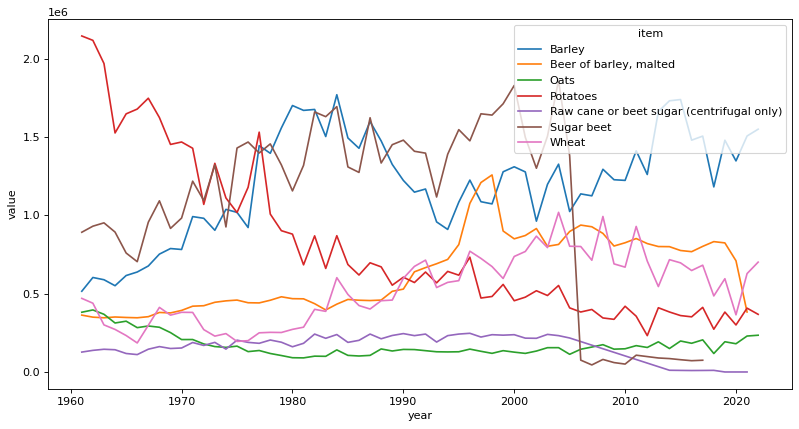

In [16]:
figure(figsize=(12, 6), dpi=80)
_ = sns.lineplot(data=top_irish_crops[top_irish_crops.element == 'Production'], x='year', y='value', hue='item')
_ = plt.show()

From: https://plotly.com/python/line-charts/

In [17]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.tools as tls


In [18]:
app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Dropdown(
                id="area",
                options=df.area.unique(),
                value="Ireland",
            ),
            dcc.RadioItems(
                PERCENTILE_LABELS,
                PERCENTILE_LABELS[-1],
                id="percentile",
                inline=True,
            )
        ], style={'width': '40%', 'display': 'inline-block'}),
    ]),
    dcc.Graph(id="line-graph"),
    dcc.Graph(id="bar-graph"),
])


@app.callback([
    Output("line-graph", "figure"), 
    Output("bar-graph", "figure")], 
    Input("percentile", "value"),
    Input("area", "value"))
def update_line_chart(percentile, area):
    data=df[(df.value > 0.0) & (df.unit == 't') & (df.area == area) & (df.percentile == percentile)]
    return (px.line(data, x="year", y="value", color='item', title=f"{percentile} Crops Production in {area}"), 
            px.bar(data, x="year", y="value", color="item", title=f"{percentile} Crops Production in {area}"))


app.run_server(debug=True)

In [19]:
app_comp = Dash(__name__)

app_comp.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="item",
            options=list(set(TOP_IRISH_CROPS_PRODUCTION.tolist() + TOP_IRISH_CROPS_YIELD.tolist())),
            value="Barley",
        ),
    ], style={'width': '42%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
        dcc.Dropdown(
            id="metric",
            options=df.element.unique(),
            value="Production",
        ),
    ], style={'width': '42%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
            dcc.Checklist(
                id="areas",
                options=df.area.unique(),
                value=["Belgium", "Ireland"]
            ),
        ], style={'width': '15%', 'float': 'right', 'display': 'inline-block', "backgroundColor": "#fafbfc"}),
    html.Div([
        html.Div([
           dcc.Graph(id="graph"),
        ], style={'width': '84%', 'float': 'left'}),
    ])
])


@app_comp.callback(
    Output("graph", "figure"), 
    Input("item", "value"),
    Input("metric", "value"),
    Input("areas", "value"))
def update_line_chart(item, metric, areas):
    data=df[(df.value > 0.0) & 
            (df.item == item) & 
            (df.element == metric) & 
            (df.area.isin(areas))]
    return px.line(data, x="year", y="value", color='area')


app_comp.run_server(debug=True, port=8051)

In [20]:
df_unstacked = df.pivot(index=['year', 'area', 'item'], columns='element', values='value').reset_index(['year', 'area', 'item'])
df_unstacked.head()

ELEMENTS = ['Area harvested', 'Production', 'Yield']

element,year,area,item,Area harvested,Production,Yield
0,1961,Austria,Apples,0.0,456000.0,NaN
1,1961,Austria,Apricots,0.0,33952.0,NaN
2,1961,Austria,Asparagus,35.0,150.0,42857.0
3,1961,Austria,Barley,187648.0,511571.0,27262.0
4,1961,Austria,"Beans, dry",682.0,1160.0,17009.0


In [21]:
top_irish_crops.tail()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
267011,Crops and livestock products,Ireland,Production,Wheat,2018,t,485480,Official figure,6630,529232.56,75-100%
267012,Crops and livestock products,Ireland,Production,Wheat,2019,t,595360,Official figure,6630,529232.56,75-100%
267013,Crops and livestock products,Ireland,Production,Wheat,2020,t,364920,Official figure,6630,529232.56,75-100%
267014,Crops and livestock products,Ireland,Production,Wheat,2021,t,628080,Official figure,6630,529232.56,75-100%
267015,Crops and livestock products,Ireland,Production,Wheat,2022,t,701240,Official figure,6630,529232.56,75-100%


In [22]:
top_irish_crops_unstacked = top_irish_crops.pivot(index=['year', 'area', 'item'], columns='element', values='value').reset_index(['year', 'area', 'item'])
top_irish_crops_unstacked.tail()
top_irish_crops_unstacked.shape

element,year,area,item,Area harvested,Production,Yield
1009,2022,Ireland,Potatoes,8490.0,367950.0,433392.0
1010,2022,Ireland,"Pumpkins, squash and gourds",NaN,NaN,63846.0
1011,2022,Ireland,Spinach,NaN,NaN,100000.0
1012,2022,Ireland,Tomatoes,NaN,NaN,3690000.0
1013,2022,Ireland,Wheat,67230.0,701240.0,NaN


(1014, 6)

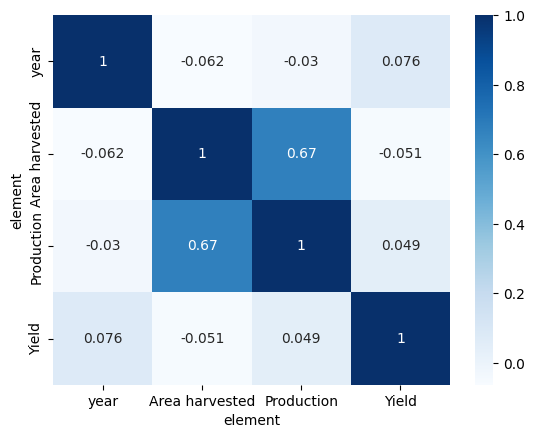

In [23]:
corr = df_unstacked[['year', 'Area harvested', 'Production', 'Yield']].dropna().corr()
sns.heatmap(corr, cmap="Blues", annot=True);

We can see a 0.67 correlation between Area harvested & Production, which means that potentially one of these variables can be discarded for future ML purposes.

In [24]:
df_unstacked.head()

element,year,area,item,Area harvested,Production,Yield
0,1961,Austria,Apples,0.0,456000.0,NaN
1,1961,Austria,Apricots,0.0,33952.0,NaN
2,1961,Austria,Asparagus,35.0,150.0,42857.0
3,1961,Austria,Barley,187648.0,511571.0,27262.0
4,1961,Austria,"Beans, dry",682.0,1160.0,17009.0


<Figure size 550x550 with 0 Axes>

Text(0.5, 1.0, 'Barley production & Yield in Ireland 1961-2022')

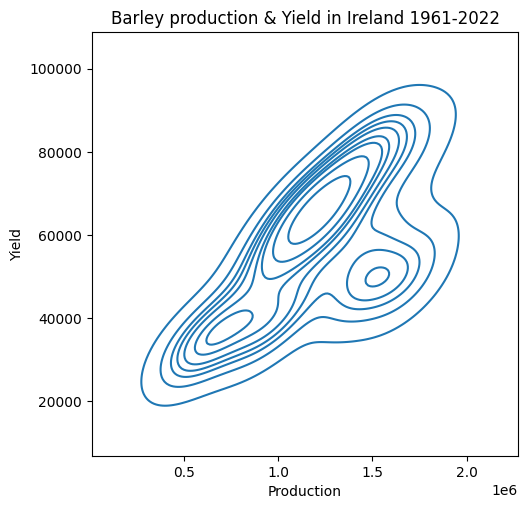

In [25]:
plt.figure(figsize=(5.5, 5.5))

irl_braley_prod = df_unstacked[(df_unstacked.area == 'Ireland') & (df_unstacked.item == 'Barley')]

g = sns.kdeplot(irl_braley_prod, x='Production', y='Yield')
g.set_title('Barley production & Yield in Ireland 1961-2022')
#plt.savefig('plots/ch1/B07887_01_02.png', format='png', dpi=300)

# Statistics

In [26]:
#Importing libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats import weightstats

#Importing the libraries
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy as scipy

from statsmodels.tsa.stattools import adfuller


In [27]:
# https://www.kaggle.com/code/brekhnaa/analysis-of-variance-anova

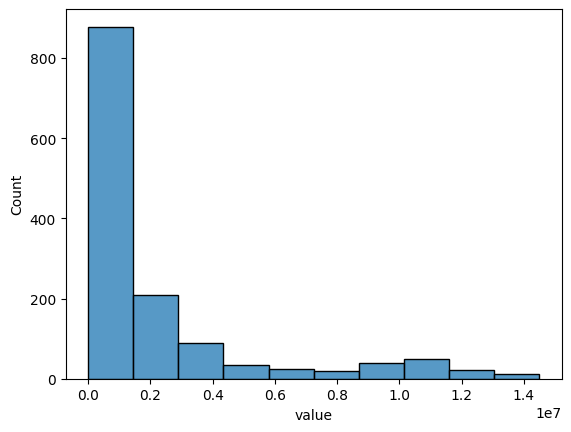

In [28]:
barley_data = df[(df.element == 'Production') & (df.item == 'Barley')]
_ = sns.histplot(data=barley_data, x='value', bins=10)


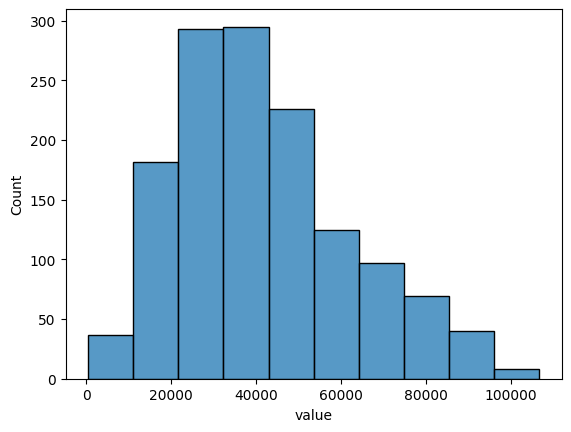

In [29]:
wheat_yield = df[(df.value > 0.0) & (df.item == 'Wheat') & (df.element == 'Yield')]
_ = sns.histplot(data=wheat_yield, x='value', bins=10)


In [30]:
def filter_df(df, item, metric, area, year):
    return df[(df.value > 0.0) & (df.item == item) & (df.element == metric) & (df.area == area) & (df.year >= year)]

Based on the graph above epxlore similarities between barley production in Ireland vs Sweden

In [31]:
# Barley Sweden vs Ireland

X1 = filter_df(df, 'Barley', 'Production', 'Ireland', 1961)
X2 = filter_df(df, 'Barley', 'Production', 'Sweden', 1961)

t_test_barley = stats.ttest_ind(X1.value, X2.value, equal_var = False)
t_test_barley

TtestResult(statistic=-8.274887082484733, pvalue=2.108363734344893e-13, df=119.35353288843136)

As pvalue is lower than alpha, we reject the null hypothesis.

**Interpretation**: With a 5% significance level, there is enough evidence to say that there are differences between Itish and Swedish barley production as observed from year 1961 until 2022.

In [32]:
# Barley Sweden vs Ireland post 2006
X1 = filter_df(df, 'Barley', 'Production', 'Ireland', 2006)
X2 = filter_df(df, 'Barley', 'Production', 'Sweden', 2006)

t_test_barley = stats.ttest_ind(X1.value, X2.value, equal_var = False)
t_test_barley

TtestResult(statistic=-1.1251166718413368, pvalue=0.2692174781299017, df=30.849374886060687)

As pvalue is higher than alpha, we **accept** the null hypothesis.

**Interpretation**: With a 5% significance level, there is enough evidence to say that there are NO differences between Itish and Swedish barley production as observed from year 2006 until 2022.

Assumption is that one of the contributing factors could be introduction of CAP.

In [33]:

# Oats Czechia vs Ireland post 2006
X1 = filter_df(df, 'Oats', 'Production', 'Ireland', 2006)
X2 = filter_df(df, 'Oats', 'Production', 'Czechia', 2006) 

t_test_oats = stats.ttest_ind(X1.value, X2.value, equal_var = False)
t_test_oats

TtestResult(statistic=2.1492199461011676, pvalue=0.04159312462200444, df=24.746714809060233)

### Check whether Barley production in Ireland is normally distributed.
Null Hypothesis H0: Barley production in Ireland follows normal distribution.

In [34]:
k2, p = stats.normaltest(filter_df(df, 'Barley', 'Production', 'Ireland', 1961).value)
alpha = 0.05
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.199551
The null hypothesis cannot be rejected


Check if wheat yield in Ireland is normally distributed

In [35]:
k2, p = stats.normaltest(df[(df.value > 0.0) & (df.area == 'Ireland') & (df.item == 'Wheat') & (df.element == 'Yield')].value)
alpha = 0.05
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 2.01955e-05
The null hypothesis can be rejected


In [36]:
df_unstacked.head()

element,year,area,item,Area harvested,Production,Yield
0,1961,Austria,Apples,0.0,456000.0,NaN
1,1961,Austria,Apricots,0.0,33952.0,NaN
2,1961,Austria,Asparagus,35.0,150.0,42857.0
3,1961,Austria,Barley,187648.0,511571.0,27262.0
4,1961,Austria,"Beans, dry",682.0,1160.0,17009.0


/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_46340/4154315805.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



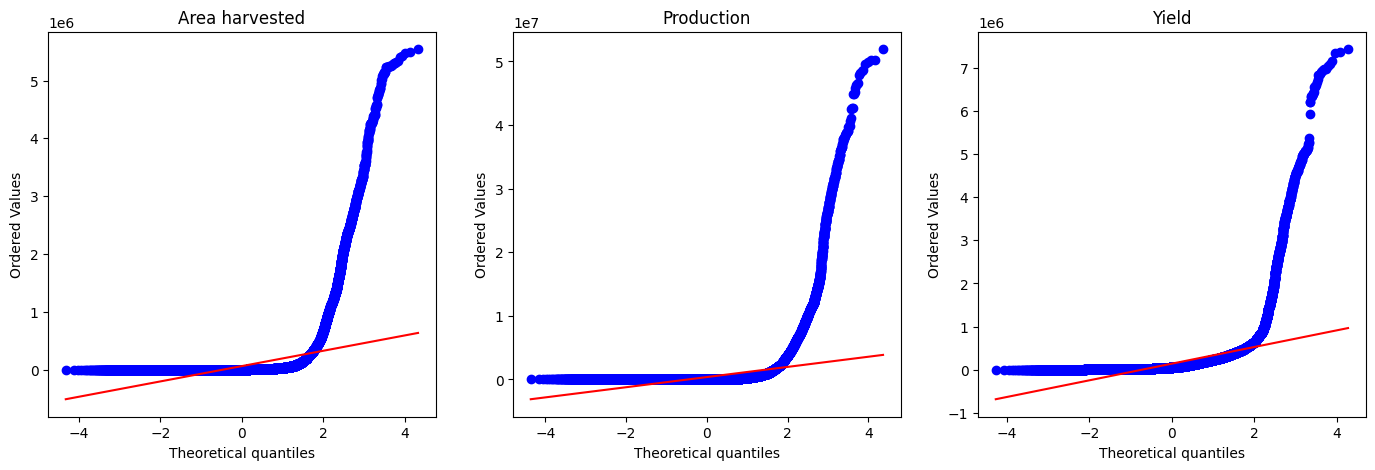

In [37]:
#Check normality of the data for Production & Yield & Area Harvested
# Probability plot - QQ plot
# https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html

f, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, element in enumerate(ELEMENTS):
   _ = stats.probplot(df_unstacked[element].dropna(), plot=axes[i]);
   _ = axes[i].set_title(element);
  #plt.figure();
f.show()

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_46340/427128009.py:7: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



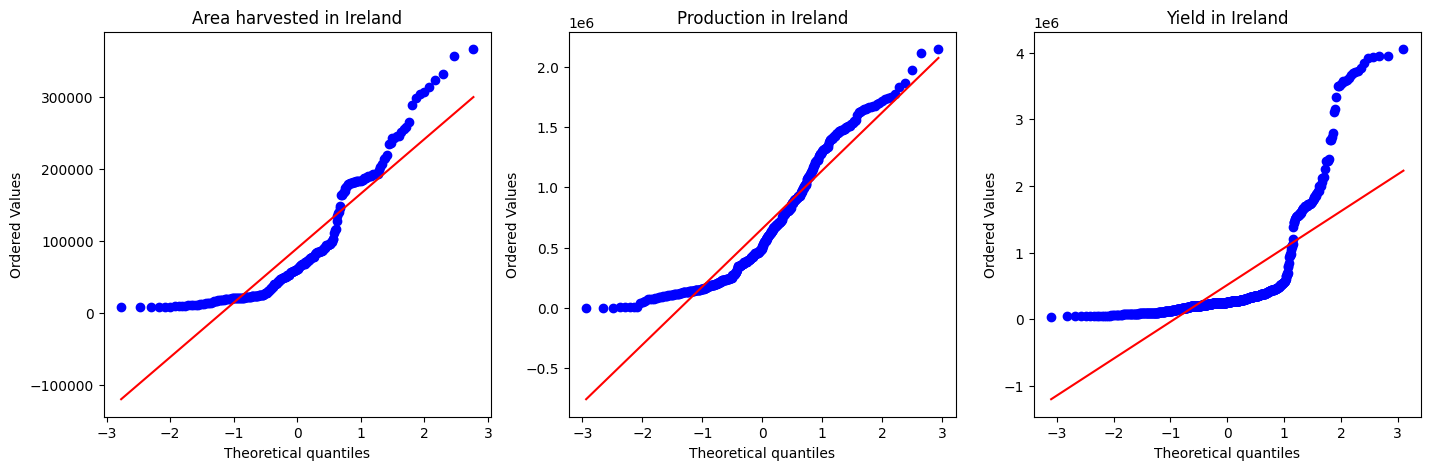

In [38]:
f, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, element in enumerate(ELEMENTS):
   _ = stats.probplot(top_irish_crops_unstacked[element].dropna(), plot=axes[i]);
   _ = axes[i].set_title(element + ' in Ireland');
  #plt.figure();
f.show()

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_46340/3692659371.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



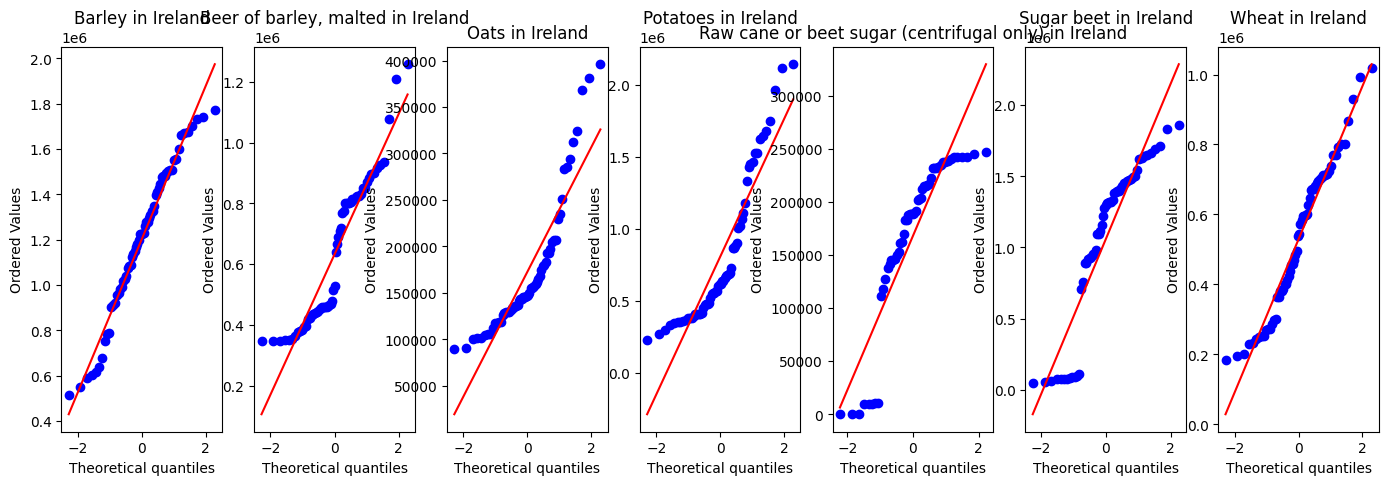

In [39]:
f, axes = plt.subplots(1, len(TOP_IRISH_CROPS_PRODUCTION), figsize=(17, 5))

for j, crop in enumerate(TOP_IRISH_CROPS_PRODUCTION):
    data = top_irish_crops_unstacked[top_irish_crops_unstacked.item == crop]["Production"].dropna()
    if data.shape[0] > 10:
      _ = stats.probplot(data, plot=axes[j]);
    _ = axes[j].set_title(crop + ' in Ireland');
  #plt.figure();
f.show()

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_46340/122354407.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



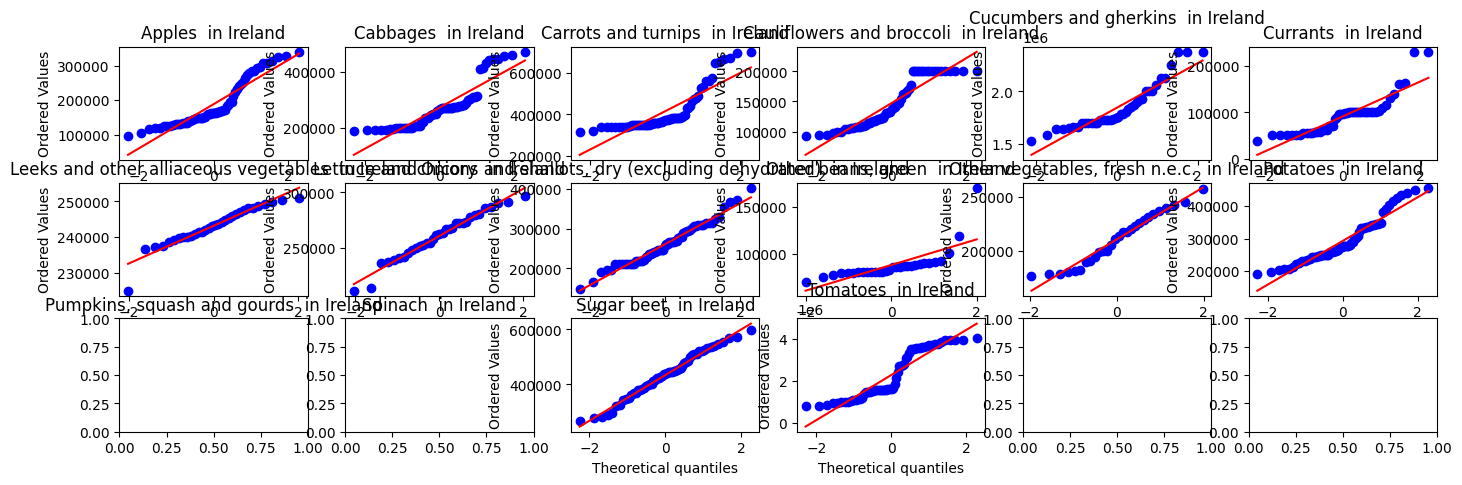

In [40]:
import math

cols = math.ceil(len(TOP_IRISH_CROPS_YIELD)/3)
i = 0
f, axes = plt.subplots(3, cols, figsize=(17, 5))


for j, crop in enumerate(TOP_IRISH_CROPS_YIELD):
    data = top_irish_crops_unstacked[top_irish_crops_unstacked.item == crop]["Yield"].dropna()
    
    row = math.floor(j/cols)
    if i > 5:
      i = 0
    col = i
    i += 1

    if data.shape[0] > 10:
      _ = stats.probplot(data, plot=axes[row , col]);
    _ = axes[row, col].set_title(crop + '  in Ireland');
  #plt.figure();
f.show()

In [41]:
df_unstacked = df_unstacked.dropna()

In [42]:
# Shapiro Wilk Test - Normality test
# This test is hypothesis test that will hel design if the data is normal or not
# H0 - data normally distributed
# H1 - data NOT normally distributed

SHAPIRO_MAX_SAMPLE = 5000

for element in ELEMENTS:
   res = stats.shapiro(df_unstacked[element].dropna())
   print(f"{element}: {res}")
    
   res_sampled = stats.shapiro(df_unstacked[element].dropna().sample(n=SHAPIRO_MAX_SAMPLE, random_state=1))
   print(f"{element}, sampled: {res_sampled}")

   print("Pvalue difference of ", res.pvalue - res_sampled.pvalue, "\n")


Area harvested: ShapiroResult(statistic=0.23145123632085662, pvalue=2.782968286839086e-165)
Area harvested, sampled: ShapiroResult(statistic=0.25756006502015516, pvalue=6.259060549683202e-89)
Pvalue difference of  -6.259060549683202e-89 

Production: ShapiroResult(statistic=0.20682108608568373, pvalue=2.4864725507380968e-166)
Production, sampled: ShapiroResult(statistic=0.23131058984414032, pvalue=1.0057674410013623e-89)
Pvalue difference of  -1.0057674410013623e-89 

Yield: ShapiroResult(statistic=0.3178338093048261, pvalue=2.3924122830009124e-161)
Yield, sampled: ShapiroResult(statistic=0.28240777591341726, pvalue=3.723304637212965e-88)
Pvalue difference of  -3.723304637212965e-88 



/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_46340/1981336570.py:9: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 70480.



**Interpretation**: Reject hypothesis, becasue P is smaller than Alpha

In [43]:
top_irish_crops.head()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,percentile
260636,Crops and livestock products,Ireland,Yield,Apples,1961,100 g/ha,96667,Estimated value,157,188430.4,75-100%
260637,Crops and livestock products,Ireland,Yield,Apples,1962,100 g/ha,103333,Estimated value,157,188430.4,75-100%
260638,Crops and livestock products,Ireland,Yield,Apples,1963,100 g/ha,116667,Estimated value,157,188430.4,75-100%
260639,Crops and livestock products,Ireland,Yield,Apples,1964,100 g/ha,120000,Estimated value,157,188430.4,75-100%
260640,Crops and livestock products,Ireland,Yield,Apples,1965,100 g/ha,140000,Estimated value,157,188430.4,75-100%


In [44]:
# Now we can analyse normality by Product and Category (yield / production)
alpha = 0.05

results = []
for item in TOP_IRISH_CROPS_PRODUCTION:
    for area in df_unstacked.area.unique():
        crop_df = df_unstacked[(df_unstacked.item == item) & (df_unstacked.area == area)]
        for element in ELEMENTS:
            crop_el_df = crop_df[element]
            if crop_el_df.shape[0] < 3:
                continue
            res_sampled = stats.shapiro(crop_el_df)
            # if res_sampled.pvalue < alpha, then null hypothesis: x comes from a normal distribution
            results.append([item, area, element, crop_df.shape[0], res_sampled.pvalue, not (res_sampled.pvalue < alpha)])

In [45]:
shapiro_per_category = pd.DataFrame(data=results, columns=['item', 'area', 'element', 'sample_size', 'pval', 'is_normal'])
shapiro_per_category.head(100)
shapiro_per_category.shape

,item,area,element,sample_size,pval,is_normal
0,Barley,Austria,Area harvested,62,2.871147e-02,False
1,Barley,Austria,Production,62,3.836077e-02,False
2,Barley,Austria,Yield,62,4.768819e-01,True
3,Barley,Bulgaria,Area harvested,62,4.627617e-01,True
4,Barley,Bulgaria,Production,62,8.929668e-03,False
...,...,...,...,...,...,...
95,Oats,Finland,Yield,62,5.628891e-02,True
96,Oats,France,Area harvested,62,1.377821e-07,False
97,Oats,France,Production,62,1.047801e-06,False
98,Oats,France,Yield,62,7.851284e-03,False


(393, 6)

In [46]:
shapiro_per_category[shapiro_per_category.is_normal == True].shape
shapiro_per_category[shapiro_per_category.is_normal == False].shape

(151, 6)

(242, 6)

In [47]:
shapiro_per_category[shapiro_per_category.is_normal == True].item.unique()


array(['Barley', 'Oats', 'Potatoes', 'Sugar beet', 'Wheat'], dtype=object)

##### Levene Test
Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

The Levene test is less sensitive than the Bartlett test to departures from normality. If you have strong evidence that your data do in fact come from a normal, or nearly normal, distribution, then Bartlett's test has better performance.
https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm#:~:text=Levene's%20test%20is%20an%20alternative,Bartlett's%20test%20has%20better%20performance.

In [48]:
# Levene test on Barley Yield
dfs = [filter_df(df, 'Barley', 'Yield', 'Ireland', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Germany', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'France', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Belgium', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Denmark', 2006).value, 
       filter_df(df, 'Barley', 'Yield', 'Netherlands (Kingdom of the)', 2006).value]

stats.levene(*dfs, center = 'mean')
stats.bartlett(*dfs)

LeveneResult(statistic=1.3615854886536825, pvalue=0.24563360972459522)

BartlettResult(statistic=5.5483829539909, pvalue=0.352669678198435)

**Interpretation**: accept that all inout samples are from populations with equal variances.

In [49]:
stats.levene(filter_df(df, 'Oats', 'Production', 'Ireland', 2006).value, 
            filter_df(df, 'Oats', 'Production', 'Czechia', 2006).value, 
            center = 'mean')

LeveneResult(statistic=5.874194676640041, pvalue=0.02119514502306541)

In [50]:
# ANOVA ######
# H0: Average cgarges the same for all locations
# H1: There is at least one average difference than others
# ols('X~categorical variable')

data = df_unstacked[df_unstacked.area.isin(['Ireland', 'Germany', 'France', 'Belgium', 'Denmark', 'Netherlands (Kingdom of the)'])]

model = ols('Yield~area', data=data).fit()
aov = sm.stats.anova_lm(model, type=2)
aov

,df,sum_sq,mean_sq,F,PR(>F)
area,5.0,2.666526e+14,5.333053e+13,140.457877,5.941663e-146
Residual,14373.0,5.457292e+15,3.796906e+11,NaN,NaN


**Conclusion** At 5% significance level there is NOT enough evidence to suggest that the average yilds are the same across the countries.
Reject the Null hypothesis

### Stationary vs Nonstationary data for time series analysis

Stationarity. A common assumption in many time series techniques is that the data are stationary. A stationary process has the property that the mean, variance and autocorrelation structure do not change over time.

Resources:
1. Concise explanation of implications: https://medium.com/@ritusantra/stationarity-in-time-series-887eb42f62a9
2. Time Series Analysis and Its Applications: With R Examples, Third Edition, by Robert H. Shumway and David S. Stoffer, Springer Verlag.
3. Time Series Analysis and Forecasting by Example, 1st Edition, by Søren Bisgaard and Murat Kulahci, John Wiley & Sons.
4. Practical Time Series Analysis: Prediction with Statistics and Machine Learning Paperback – 1 Nov. 2019
5. https://github.com/PacktPublishing/Practical-Time-Series-Analysis

In [51]:
result = adfuller(df_unstacked['Yield'].values)
result
print('p-value: %s' % result[1])

(-30.07013755882016,
 0.0,
 61,
 70418,
 {'1%': -3.4304428674258367,
  '5%': -2.8615810457572604,
  '10%': -2.5667918472534064},
 1989151.5613137127)

p-value: 0.0


In [52]:
result = adfuller(df_unstacked[(df_unstacked.area == 'Ireland') & (df_unstacked.item == 'Barley')]['Yield'].values)
result
print('p-value: %s' % result[1])

(-0.706200183985643,
 0.8451370071772577,
 3,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 1017.7347966818014)

p-value: 0.8451370071772577


## Time Series

In [53]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from prophet import Prophet

from pandas import to_datetime
import warnings



In [54]:
df_unstacked.head()
df_unstacked = df_unstacked.sort_values(by='year')
df_unstacked.head()


element,year,area,item,Area harvested,Production,Yield
2,1961,Austria,Asparagus,35.0,150.0,42857.0
3,1961,Austria,Barley,187648.0,511571.0,27262.0
4,1961,Austria,"Beans, dry",682.0,1160.0,17009.0
6,1961,Austria,"Broad beans and horse beans, dry",659.0,1635.0,24810.0
8,1961,Austria,Buckwheat,224.0,256.0,11429.0


element,year,area,item,Area harvested,Production,Yield
2,1961,Austria,Asparagus,35.0,150.0,42857.0
927,1961,Malta,"Onions and shallots, dry (excluding dehydrated)",330.0,2537.0,76879.0
933,1961,Malta,"Other vegetables, fresh n.e.c.",1640.0,11000.0,67073.0
938,1961,Malta,Potatoes,3296.0,25349.0,76908.0
939,1961,Malta,"Pumpkins, squash and gourds",403.0,1093.0,27122.0


In [55]:
df_ireland_barley = df_unstacked[(df_unstacked.area == "Ireland") & (df_unstacked.item == "Barley")].reset_index().sort_values(by='year')

X = df_ireland_barley.year
y = df_ireland_barley.Production
X
y


0     1961
1     1962
2     1963
3     1964
4     1965
      ... 
57    2018
58    2019
59    2020
60    2021
61    2022
Name: year, Length: 62, dtype: int64

0      515400.0
1      603200.0
2      588900.0
3      550699.0
4      615730.0
        ...    
57    1181560.0
58    1479600.0
59    1347460.0
60    1506410.0
61    1549860.0
Name: Production, Length: 62, dtype: float64

In [56]:

def plot_timeseries_split(X, y, n_splits=3):
    folds = TimeSeriesSplit(n_splits=n_splits)

    f, ax = plt.subplots(nrows=n_splits, ncols=2, figsize=(16, 9))
    
    for i, (train_index, valid_index) in enumerate(folds.split(X)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
    
        _ = sns.lineplot(
            x=X_train, 
            y=y_train, 
            ax=ax[i,0], 
            color='dodgerblue', 
            label='train'
        )
        _ = sns.lineplot(
            x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
            y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
            ax=ax[i,1], 
            color='dodgerblue', 
            label='train'
        )
    
        for j in range(2):
            sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
        ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16);
        ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16);
    
    for i in range(n_splits):
        ax[i, 0].set_xlim([1961, 2024]);
        ax[i, 1].set_xlim([1961, 2024]);
        
    plt.tight_layout()
    plt.show()

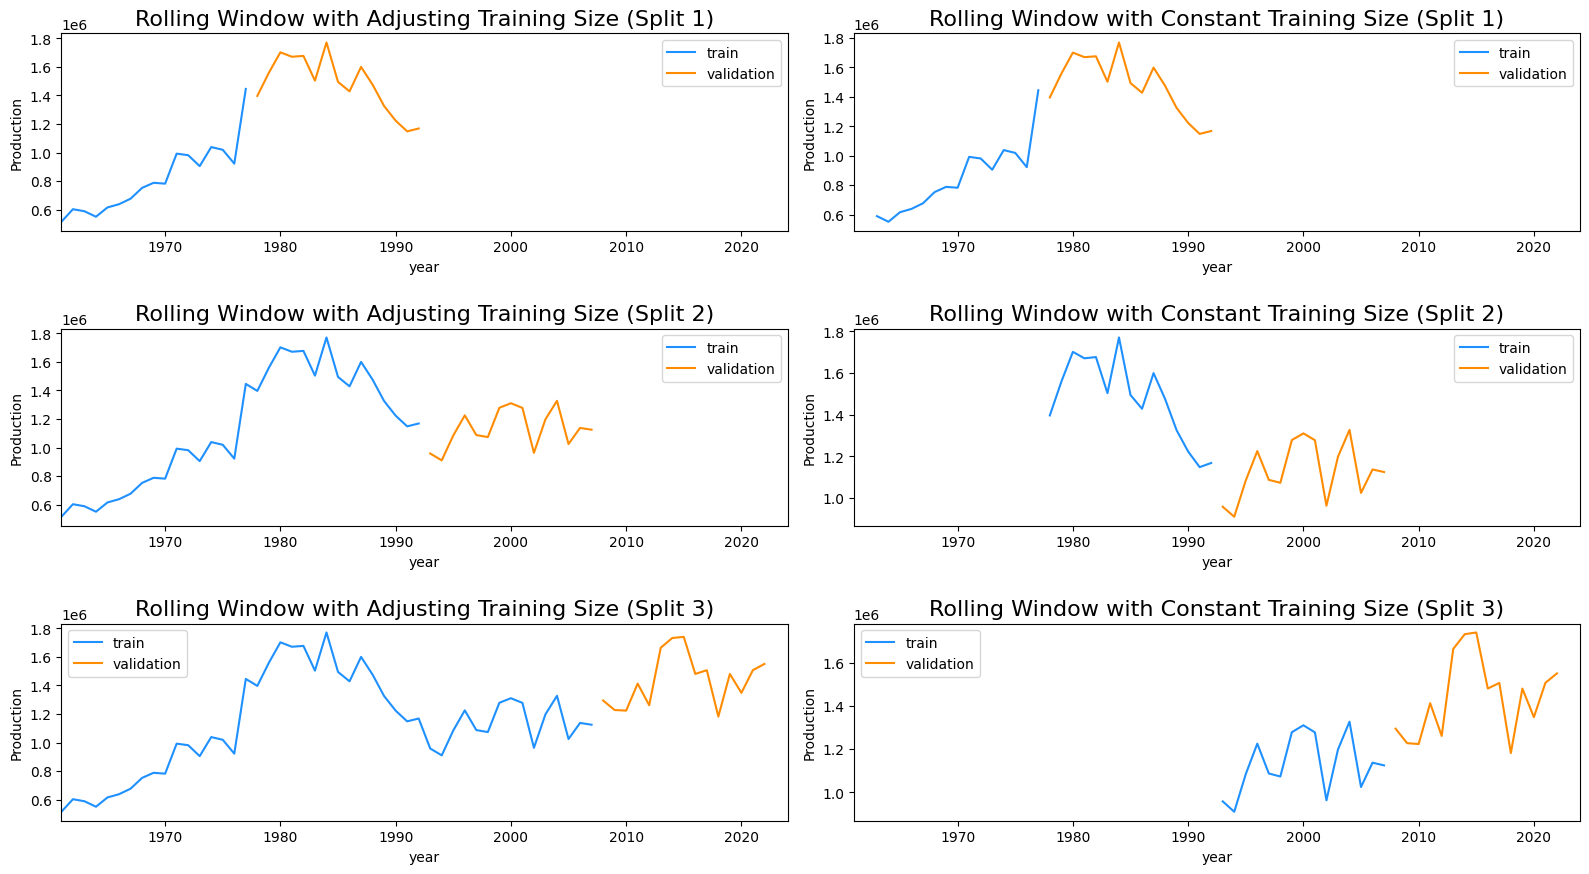

In [57]:
plot_timeseries_split(X, y)

In [79]:
X.shape

(62,)

Terminology: `yhat` - The estimated or predicted values in a regression or other predictive model are termed the y-hat values. “Y” because y is the outcome or dependent variable in the model equation, and a “hat” symbol (circumflex) placed over the variable name is the statistical designation of an estimated value.

### Meta (formerly, Facebook) open-source Prophet library

In [133]:
def split_and_prep_univariate(univariate_df):
    train_size = int(0.85 * len(univariate_df))
    
    univariate_df.year = to_datetime(univariate_df.year.apply(lambda x: str(x) + '-01-01'))
    univariate_df.columns = ['ds', 'y']
    
    train = univariate_df.iloc[:train_size, :]
    
    x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
    x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

    return train, x_train, y_train, x_valid, y_valid

In [134]:
def split_and_prep_multivariate(multivariate_df, target_column):
    feature_columns = [
      'item',
    ]
    
    train_size = int(0.85 * len(multivariate_df))
    
    multivariate_df = multivariate_df[['year'] + [target_column] + feature_columns].copy()
    multivariate_df.columns = ['ds', 'y'] + feature_columns
    
    train = multivariate_df.iloc[:train_size, :]
    x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
    x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])
    
    train.head()

    return train, x_train, y_train, x_valid, y_valid

In [135]:
#pip install prophet --no-binary :all:

In [136]:
warnings.filterwarnings("ignore")

def train_prophet(model, train, x_valid, y_valid, y_label):
    # Train the model
    model.fit(train)
    
    # x_valid = model.make_future_dataframe(periods=test_size, freq='w')
    
    # Predict on valid set
    y_pred = model.predict(x_valid)
    y_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    # Calcuate metrics
    score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
    score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))
    
    print('RMSE: {}'.format(score_rmse))
    # Plot the forecast
    f, ax = plt.subplots(1)
    f.set_figheight(3)
    f.set_figwidth(7)

    _ = model.plot(y_pred, ax=ax)
    _ = sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')
    
    ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14);
    ax.set_xlabel(xlabel='Year', fontsize=8);
    ax.set_ylabel(ylabel=y_label, fontsize=8);
    
    return f


In [137]:
plt.ion()

(52, 2)
52
52
10
10


(None, None, None, None, None)

22:53:39 - cmdstanpy - INFO - Chain [1] start processing
22:53:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 204202.2964015876


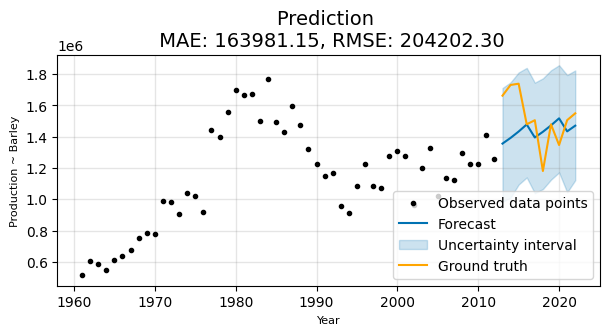

In [138]:
univariate_df = df_unstacked[(df_unstacked.area == "Ireland") & (df_unstacked.item == "Barley")].reset_index().sort_values(by='year')[['year', 'Production']]
train, x_train, y_train, x_valid, y_valid = split_and_prep_univariate(univariate_df)

print(train.shape), print(x_train.size), print(y_train.size), print(x_valid.size), print(y_valid.size)

model = Prophet(growth="linear")
_ = train_prophet(model, train, x_valid, y_valid, 'Production ~ Barley')

22:53:45 - cmdstanpy - INFO - Chain [1] start processing


(52, 2) 52 10


22:53:46 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 7448.017812342199


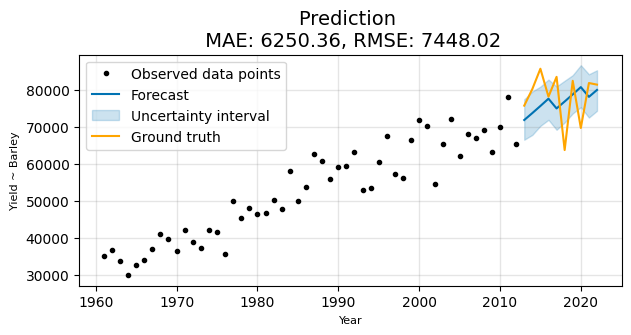

In [139]:
univariate_df = df_unstacked[(df_unstacked.area == "Ireland") & (df_unstacked.item == "Barley")].reset_index().sort_values(by='year')[['year', 'Yield']]
train, x_train, y_train, x_valid, y_valid = split_and_prep_univariate(univariate_df)
print(train.shape, len(x_train), len(x_valid))

model_yield = Prophet(growth="linear")
_ = train_prophet(model_yield, train, x_valid, y_valid, 'Yield ~ Barley')


In [140]:
RESULT_PLOTS = {}
RF_MODELS = {}

In [141]:
plt.ioff()

for metric in ['Yield', 'Production']:
    for area in df_unstacked.area.unique()[:2]:
        area_data = df_unstacked[(df_unstacked.area == area)].reset_index()
        for item in df_unstacked.item.unique()[:2]:
            area_item_df_uni = area_data[(area_data.item == item)].reset_index().sort_values(by='year')[['year', metric]]
            if len(area_item_df_uni) < 10:
                RF_MODELS[f'{metric}_{area}_{item}'] = None
                continue
            
            train, x_train, y_train, x_valid, y_valid = split_and_prep_univariate(area_item_df_uni)
            print(train.shape, len(x_train), len(x_valid))
            
            model = Prophet(growth="linear")
            res_plot = train_prophet(model, train, x_valid, y_valid, f'{metric} ~ {area} ~ {item}')

            RESULT_PLOTS[f'{metric}_{area}_{item}'] = res_plot
            RF_MODELS[f'{metric}_{area}_{item}'] = model

22:53:51 - cmdstanpy - INFO - Chain [1] start processing


(52, 2) 52 10


22:53:51 - cmdstanpy - INFO - Chain [1] done processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 15505.484341035928
(52, 2) 52 10


22:53:51 - cmdstanpy - INFO - Chain [1] done processing
22:53:51 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 107851.71782020853
(48, 2) 48 9


22:53:52 - cmdstanpy - INFO - Chain [1] done processing
22:53:52 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 14736.570308008379
(52, 2) 52 10


22:53:52 - cmdstanpy - INFO - Chain [1] done processing
22:53:52 - cmdstanpy - INFO - Chain [1] start processing


RMSE: 679.4369462125674
(52, 2) 52 10


22:53:52 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 23463.66176223477
(48, 2) 48 9


22:53:53 - cmdstanpy - INFO - Chain [1] start processing
22:53:53 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 2034.9629337735905


In [116]:
RESULT_PLOTS

{'Yield_Austria_Asparagus': <Figure size 700x300 with 1 Axes>,
 'Yield_Austria_Onions and shallots, dry (excluding dehydrated)': <Figure size 700x300 with 1 Axes>,
 'Yield_Malta_Onions and shallots, dry (excluding dehydrated)': <Figure size 700x300 with 1 Axes>,
 'Production_Austria_Asparagus': <Figure size 700x300 with 1 Axes>,
 'Production_Austria_Onions and shallots, dry (excluding dehydrated)': <Figure size 700x300 with 1 Axes>,
 'Production_Malta_Onions and shallots, dry (excluding dehydrated)': <Figure size 700x300 with 1 Axes>}

In [142]:
plt.ion()


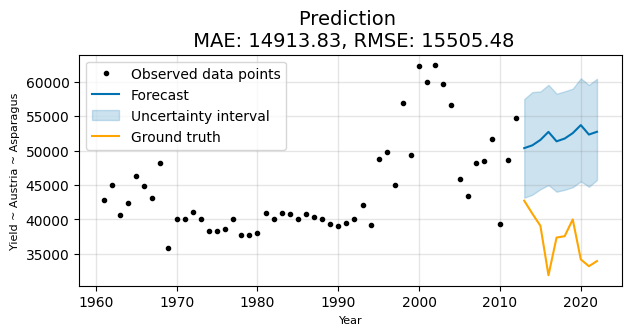

In [143]:
RESULT_PLOTS['Yield_Austria_Asparagus']

In [501]:
# multivariate_df = df_unstacked[(df_unstacked.area == "Ireland")].reset_index().sort_values(by='year')[['year', 'item', 'Yield']]

# enc = OrdinalEncoder()
# enc.fit(multivariate_df[['item']])
# multivariate_df.item = enc.transform(multivariate_df[['item']]) # instead of multivariate_df.item, need to do multivariate_df[['item']]), because OrdinalEncoder expect a Dataframe, and not a Series.

# train, x_train, y_train, x_valid, y_valid = split_and_prep_multivariate(multivariate_df, 'Yield')

# print(train.shape, len(x_train), len(x_valid))
# print(train)
# print(x_train.shape)
# print(y_train.shape)
# print(x_valid.shape)
# print(y_valid.shape)

# model_multi = Prophet()
# model_multi.add_regressor('item')

# train_prophet(model_multi, train, x_valid, y_valid, 'Yield ~ Barley')

### Random Forest & Linear Regression on Time Series


https://www.ine.pt/revstat/pdf/Randomforestsfortimeseries.pdf

In [64]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, Ridge


In [65]:
def split_and_prep_multivariate(X, y):
    train_size = int(0.75 * len(X))
        
    x_train, y_train = pd.DataFrame(X[:train_size]), pd.DataFrame(y[:train_size])
    x_valid, y_valid = pd.DataFrame(X[train_size:]), pd.DataFrame(y[train_size:])

    return x_train, y_train, x_valid, y_valid

In [66]:
def train_regressor(model, x_train, y_train, x_valid, y_valid):
    model.fit(x_train, y_train)
    print("Test-set R^2: {:.2f}".format(model.score(x_valid, y_valid)))
    
    y_pred_valid = model.predict(x_valid)
    y_pred_train = model.predict(x_train)

    train = x_train
    train['Ground Truth'] = y_train
    train['Predicted'] = y_pred_train

    validate = x_valid
    validate['Ground Truth'] = y_valid
    validate['Predicted'] = y_pred_valid

    return pd.concat([train, validate])

In [67]:
RESULTS = {}
RF_MODELS = {}

In [68]:
### ~~~ Yield ~~~ ###

__metric = 'Yield'

yield_multivariate_df = df_unstacked[(df_unstacked.area == "Ireland")].sort_values(by='year').reset_index()[['year', 'item', __metric]]

enc = OrdinalEncoder()
enc.fit(yield_multivariate_df[['item']])
yield_multivariate_df.item = enc.transform(yield_multivariate_df[['item']]) # instead of multivariate_df.item, need to do multivariate_df[['item']]), because OrdinalEncoder expect a Dataframe, and not a Series.

OrdinalEncoder()

In [69]:
__model = 'RandomForest'

rf_model = RandomForestRegressor(n_estimators = 100, random_state = 0)

results = train_regressor(rf_model, 
                          *split_and_prep_multivariate(yield_multivariate_df[['year', 'item']], yield_multivariate_df[__metric]))

results.item = enc.inverse_transform(results[['item']]).T[0] # Decode the crop values
results = pd.melt(results, id_vars=['year', 'item'], value_vars=['Ground Truth', 'Predicted'])
results.head(5)

RESULTS[__metric + __model] = results
RF_MODELS[__metric + __model] = rf_model


/usr/local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Test-set R^2: 0.98


,year,item,element,value
0,1961,Apples,Ground Truth,96667.0
1,1961,Wheat,Ground Truth,33676.0
2,1961,Tomatoes,Ground Truth,800000.0
3,1961,Sugar beet,Ground Truth,279749.0
4,1961,Strawberries,Ground Truth,60000.0


In [83]:
len(yield_multivariate_df['year'].tolist())

AttributeError: 'Series' object has no attribute 'toarray'

In [82]:
__model = 'LinearRegression'

yield_multivariate_df = df_unstacked[(df_unstacked.area == "Ireland")].sort_values(by='year').reset_index()[['year', 'item', __metric]]

oh_enc = OneHotEncoder()
oh_enc.fit(yield_multivariate_df[['item']])
yield_multivariate_df_one_hot = oh_enc.transform(yield_multivariate_df[['item']]) 
yield_multivariate_df_one_hot.toarray()

np.append(yield_multivariate_df_one_hot.toarray(), yield_multivariate_df['year'].tolist(), axis=1)
# l_reg_model = LinearRegression()
# results = train_regressor(l_reg_model, 
#                           *split_and_prep_multivariate(yield_multivariate_df_one_hot.toarray(), yield_multivariate_df[__metric]))

# results
# #results.item = 
# oh_enc.inverse_transform(results.drop(columns=['Ground Truth', 'Predicted'])) # Decode the crop values
# results = pd.melt(results, id_vars=['year', 'item'], value_vars=['Ground Truth', 'Predicted'])
# results.head(5)

# RESULTS[__metric + __model] = results
# RF_MODELS[__metric + __model] = l_reg_model

OneHotEncoder()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

<Axes: xlabel='year', ylabel='value'>

<Axes: xlabel='year', ylabel='value'>

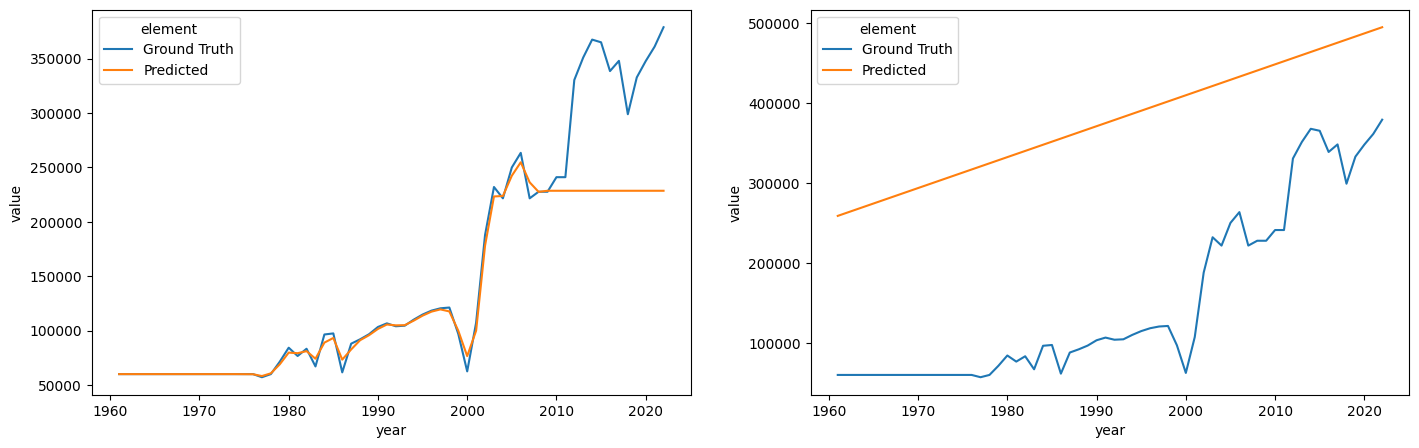

In [569]:
f, axes = plt.subplots(1, 2, figsize=(17, 5))

for i, m in enumerate(['RandomForest', 'LinearRegression']):
  res = RESULTS['Yield' + m] 
  sns.lineplot(data=res[res.item == 'Strawberries'], x='year', y='value', hue='element', ax=axes[i])

In [574]:

### ~~~ Production ~~~ ###

__metric = 'Production'

prd_multivariate_df = df_unstacked[(df_unstacked.area == "Ireland")].sort_values(by='year').reset_index()[['year', 'item', __metric]]

enc = OrdinalEncoder()
enc.fit(prd_multivariate_df[['item']])
prd_multivariate_df.item = enc.transform(prd_multivariate_df[['item']]) # instead of multivariate_df.item, need to do multivariate_df[['item']]), because OrdinalEncoder expect a Dataframe, and not a Series.

OrdinalEncoder()

In [575]:
__model = 'RandomForest'

rf_model = RandomForestRegressor(n_estimators = 100, random_state = 0)
results = train_regressor(rf_model, *split_and_prep_multivariate(prd_multivariate_df))

results.item = enc.inverse_transform(results[['item']]).T[0] # Decode the crop values
results = pd.melt(results, id_vars=['year', 'item'], value_vars=['Ground Truth', 'Predicted'])
results.head(5)

RESULTS[__metric + __model] = results
RF_MODELS[__metric + __model] = rf_model


/usr/local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Test-set R^2: 0.93


,year,item,element,value
0,1961,Apples,Ground Truth,29000.0
1,1961,Wheat,Ground Truth,469900.0
2,1961,Tomatoes,Ground Truth,11200.0
3,1961,Sugar beet,Ground Truth,892092.0
4,1961,Strawberries,Ground Truth,3000.0


In [576]:
__model = 'LinearRegression'

l_reg_model = LinearRegression()
results = train_regressor(l_reg_model, *split_and_prep_multivariate(prd_multivariate_df))

results.item = enc.inverse_transform(results[['item']]).T[0] # Decode the crop values
results = pd.melt(results, id_vars=['year', 'item'], value_vars=['Ground Truth', 'Predicted'])
results.head(5)

RESULTS[__metric + __model] = results
RF_MODELS[__metric + __model] = l_reg_model

Test-set R^2: -0.07


,year,item,element,value
0,1961,Apples,Ground Truth,29000.0
1,1961,Wheat,Ground Truth,469900.0
2,1961,Tomatoes,Ground Truth,11200.0
3,1961,Sugar beet,Ground Truth,892092.0
4,1961,Strawberries,Ground Truth,3000.0


<Axes: xlabel='year', ylabel='value'>

<Axes: xlabel='year', ylabel='value'>

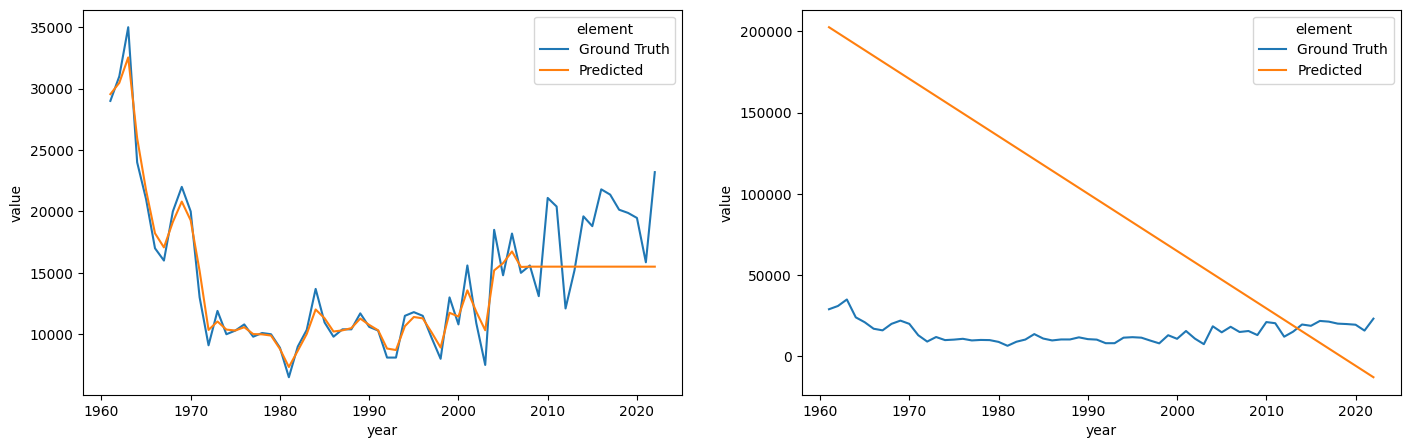

In [577]:
f, axes = plt.subplots(1, 2, figsize=(17, 5))

for i, m in enumerate(['RandomForest', 'LinearRegression']):
  res = RESULTS['Production' + m] 
  sns.lineplot(data=res[res.item == 'Apples'], x='year', y='value', hue='element', ax=axes[i])

In [578]:
app_comp = Dash(__name__)

app_comp.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="item",
            options=results.item.unique(),
            value="Barley",
        ),
    ], style={'width': '30%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
        dcc.Dropdown(
            id="metric",
            options=df.element.unique(),
            value="Production",
        ),
    ], style={'width': '30%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
        dcc.Dropdown(
            id="model",
            options=['RandomForest', 'LinearRegression'],
            value="RandomForest",
        ),
    ], style={'width': '30%', 'display': 'inline-block', "borderColor": "#66c2a5"}),
    html.Div([
        html.Div([
           dcc.Graph(id="graph"),
        ], style={'width': '90%', 'float': 'left'}),
    ])
])


@app_comp.callback(
    Output("graph", "figure"), 
    Input("item", "value"),
    Input("metric", "value"),
    Input("model", "value"),
    )
def update_line_chart(item, metric, model):
    data = RESULTS[metric + model]
    data = data[(data.item == item)]
    return px.line(data, x="year", y="value", color='element')

app_comp.run_server(debug=True, port=8056)

## Sentiment Analysis

In [ ]:
https://www.kaggle.com/code/michawilkosz/twitter-sentiment-analysis-using-tensorflow